# Modules

In [9]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, rgb2hex

from mesa import Agent, Model
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.time import SimultaneousActivation
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer

# Helper functions
Obtain the sum of the fractions across all FSM's in the CA.

In [2]:
def get_sus(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[0]
    return state

def get_exp(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[1]
    return state

def get_inf(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[2]
    return state

def get_rec(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[3]
    return state

# CA class
* Set all parameters as "global" parameters, i.e., all FSMs have the same params.
* Set a global time t (days)
* Random give some FSMs a state $(0.8, 0, 0.2, 0)$ instead of $(1, 0, 0, 0)$

In [24]:
class CellularAutomaton(Model):
    
    def __init__(
        self,
        height = 30,
        width = 30,
        mu = 0.0005, # Birth rate
        sig = 1/7,   # Rate of delay
        gam = 1/14,  # Rate of recovery
        c = 1/2,     # Connection factor between FSM
        b0 = 0.25,   # Rate of infection
        b1 = 0.2     # Amplitude of seasonality of infection
    ):
        self.height = height
        self.width = width
        
        self.mu = mu
        self.b0 = b0
        self.b1 = b1
        self.sig = sig
        self.gam = gam
        self.c = c
        
        self.t = 0
        
        self.schedule = SimultaneousActivation(self)
        self.grid = Grid(self.width, self.height, torus=True)

        self.datacollector = DataCollector(
            model_reporters =  {
                "sus": get_sus,
                "exp": get_exp,
                "inf": get_inf,
                "rec": get_rec
                }
            )
        
        np.random.seed(0)
        for (contents, i, j) in self.grid.coord_iter():
            FSM = FSM_SEIR((i,j), self)
            if np.random.random() < 0.005:
                FSM.state = [0]*4
                FSM.state[0] = 0.8
                FSM.state[2] = 0.2
            else:
                FSM.state = [0]*4
                FSM.state[0] = 1
            self.grid.place_agent(FSM, (i,j))
            self.schedule.add(FSM)

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.t += 1
        self.schedule.step()
        self.datacollector.collect(self)

    def run(self, n):
        for _ in range(n):
            self.step()

# FSM class

* States: $(S, I, E, R)$, where each of the attributes is a fraction of the form $\frac{n}{10000}, \quad n \in \mathbb{N}$. It follows that each FSM has $10001^4$ different states it can attain.
* Transition function:
$$ S_{i,j}^{t+1} = S_{i,j}^t - \beta(t) S_{i,j}^tI_{i,j}^t - c\beta(t)\sum_{k,l} I_{k,l}^t S_{i,j}^t + \mu (1 - S_{i,j}^t), $$
$$ E_{i,j}^{t+1} = E_{i,j}^t + \beta(t) S_{i,j}^tI_{i,j}^t + c\beta(t)\sum_{k,l} I_{k,l}^t S_{i,j}^t - \sigma E_{i,j}^t - \mu E_{i,j}^t,$$
$$ I_{i,j}^{t+1} = I_{i,j}^t + \sigma E_{i,j}^t - \gamma  I_{i,j}^t - \mu * I_{i,j}^t, $$
$$ R_{i,j}^{t+1} = R_{i,j}^t + \gamma I_{i,j}^t - \mu R_{i,j}^t, $$
where $\beta(t) = \beta_0 (1 + \beta_1\cos(\omega t))$.

In [4]:
# Stau, Etau, Itau, Rtau = self.state[self.model.tau-1,:]
# + np.exp(- self.model.mu * self.model.tau) * (self.model.lam * Stau * Itau + sum([self.model.lam * self.model.m * x.state[self.model.tau-1,2] * Stau for x in neighbors]))
# self._nextState[1:,:] = self.state[:self.model.tau-1,:]
# self._nextState[0,:] = [S, E, I, R]

In [49]:
class FSM_SEIR(Agent):
    def __init__(self, pos, model):
        super().__init__(pos, model)
        self.x, self.y = pos

        self.state = None
        self._nextState = None
        self.counter = 0

    def step(self):
        neighbors = self.model.grid.get_neighbors((self.x,self.y), True)
        
        S,E,I,R = self.state
        
        beta = self.model.b0 * (1 + self.model.b1 * np.cos(2 * np.pi / 365 * self.model.t))
        
        Snew = S - beta * S * I - sum([self.model.c * beta * x.state[2] * S for x in neighbors]) + self.model.mu * (1 - S)
        Enew = E + beta * S * I + sum([self.model.c * beta * x.state[2] * S for x in neighbors]) - E * self.model.sig - self.model.mu * E
        Inew = I + E * self.model.sig - I * self.model.gam - self.model.mu * I
        Rnew = R + I * self.model.gam - self.model.mu*R
        
        n = 4 
        
        # Map to state space
        S = round(Snew, 4)
        E = round(Enew, 4)
        I = round(Inew, 4)
        R = round(Rnew, 4)
        
        self._nextState = [S, E, I, R]
        
    def advance(self):
        self.state = self._nextState

# Run model

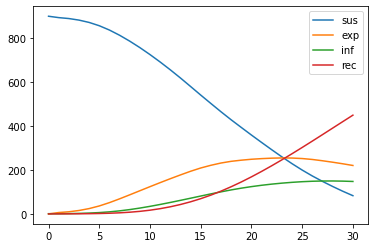

In [54]:
model = CellularAutomaton( 
        height = 30,
        width = 30,
        mu = 0.001, # Birth rate
        sig = 1/8,   # Rate of delay
        gam = 1/5,   # Rate of recovery
        c = 1/2,     # Connection factor between FSM
        b0 = 1,   # Rate of infection
        b1 = 0.3     # Amplitude of seasonality of infection
                         )

model.run(30)
    
df = model.datacollector.get_model_vars_dataframe()
df.plot()

# Plot density of infected

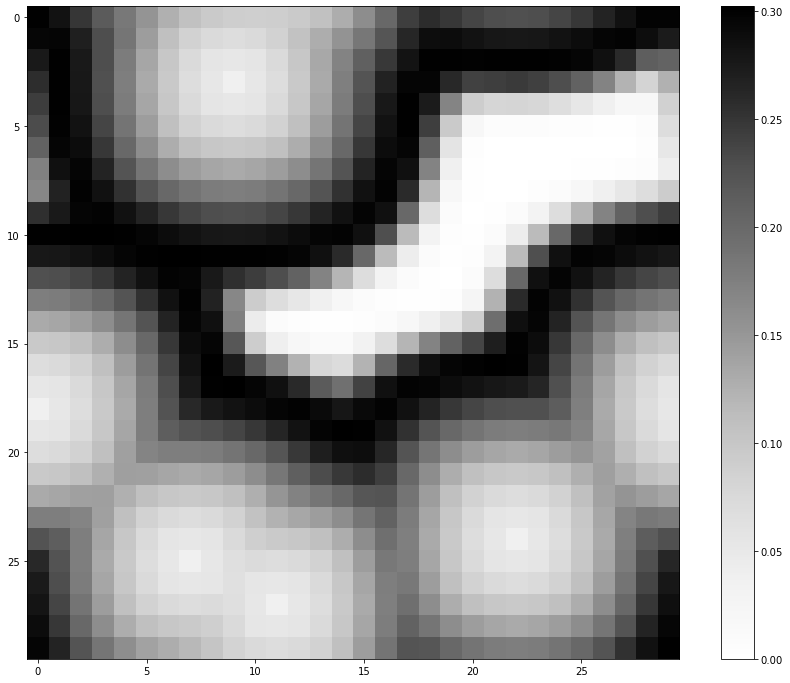

In [55]:
infected = np.zeros((30,30))
for (content, i, j) in model.grid.coord_iter():
    infected[i,j] = content.state[2]
    
plt.figure(figsize = (15,12))
plt.imshow(infected,cmap = 'Greys')
plt.colorbar()
plt.show()

# MESA server

In [8]:
norm = Normalize(vmin=0, vmax = 0.5)
cmap = cm.Greys
m = cm.ScalarMappable(norm = norm, cmap = cmap)

colordict = {}

for i in np.linspace(0,1,10001):
    k = round(10000*i)/10000
    colordict[k] = rgb2hex(m.to_rgba(k))

def portrayCell(fsm):
    assert fsm is not None
    
    portrayal = {
        "Shape": "rect",
        "w":1,
        "h":1,
        "Filled": "true",
        "Layer": 0,
        "x": fsm.x,
        "y": fsm.y
    }
    portrayal["Color"] = colordict[fsm.state[2]]
    
    return portrayal

chart = ChartModule(
    [{"Label": "sus", "Color": "#3776ab"},
     {"Label": "exp", "Color": '#ab3776'},
     {"Label": "inf", "Color": "#ab6b37"}, 
     {"Label": "rec", "Color": "#37ab6c"}],
     canvas_height=300, canvas_width=500
)

SIZE = 50

canvas_element = CanvasGrid(portrayCell, SIZE, SIZE, 500, 500 )
server = ModularServer(
    CellularAutomaton, [canvas_element,chart], "Epidemic", {"height": SIZE, 
                                                            "width":SIZE,
                                                            "mu": 0.0005, # Birth rate
                                                            "sig": 1/8,   # Rate of delay
                                                            "gam": 1/5,   # Rate of recovery
                                                            "c": 1/2,     # Connection factor between FSM
                                                            "b0": 1,      # Rate of infection
                                                            "b1": 0.2     # Amplitude of seasonality of infection
                                                           }
    )

server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
